In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd

In [65]:
from keras.datasets import mnist
from keras.models import Sequential 
from keras.layers import Dense, Flatten
from keras.utils import np_utils

#Camadas de convolução e MaxPooling 2D porque imagens são objetos 2D (ou seja, imagens)
from keras.layers import Conv2D, MaxPooling2D

In [66]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

- Dimensões

In [67]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


- Para visualizar qualquer imagem 

In [68]:
X_train[0].shape

(28, 28)

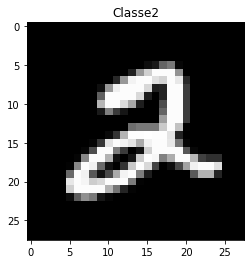

In [69]:
i = 5
plt.title('Classe' + str(y_train[5]))
plt.imshow(X_train[5], cmap = 'gray')

## Transformação para tensores

In [70]:
def array2tensor(array, channels):
    tensor = array.reshape(array.shape[0], 
                           array.shape[1],
                           array.shape[2],
                           channels)
    return tensor

In [71]:
#Como a imagem veio com apenas um canal, só passo trabalhar com 1 mesmo 
X_train = array2tensor(X_train, channels = 1)
X_test = array2tensor(X_test, channels = 1)


- Visualizar imagem

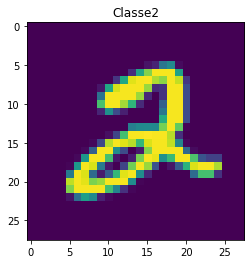

In [72]:
i = 5
plt.title('Classe' + str(y_train[i]))
plt.imshow(X_train[i,:,:,0])

- O objeto é do tipo uint8, um tipo de variável unsigned integer de 8 bits, ou seja. 
- Esta variável é sempre não negativa, representa por, por exemplo, 11111111, o qual seria o número 255

- Na notação abaixo, '0b' significa que esta é uma notação de número binário e não o número 1111111
- '0x' significa hexadecimal 
- o '0' stands for Octal, afinal, esta representação está sendo realizada em 8 bits 

In [73]:
bin(255)

'0b11111111'

In [74]:
print(type(X_train[0,0,0,0]))

<class 'numpy.uint8'>


- Para realizar as operações matemáticas na rede neural, utilizaremos o formato de float a qual permitirá a realização da normalização

In [75]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## Modificação da escala de valores
- Transformação da escala porque os números estão entre 0 e 255, o que resultaria em um tempo muito maior de treinamento da rede. 
- 255 é o valor máximo observado em cada vetor. Este valor obviamente está atrelado à escala de cores RGB

In [76]:
X_train_s = X_train/255
X_test_s = X_test/255

In [77]:
X_train_s.shape

(60000, 28, 28, 1)

### One Hot Encode (Dummy data) para codificação da saíde, porque há 10 saídas possíveis

In [78]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Validação Cruzada

In [79]:
from sklearn.model_selection import StratifiedKFold

- Semente geradora dos números aleatórios

In [80]:
seed = 5
np.random.seed(seed)

In [81]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

### Armazenar os resultados

In [82]:
resultados = []

In [83]:
a = np.zeros(5)

### Para visualizar como foi realizado a divisão
- Objeto kfold retorna os índices que serão utilizados na etapa de treinamento do modelo e na etapa de validação, na validação cruzada

In [84]:
i = 1
for train_index, test_index in kfold.split(X_train_s, y_train[:,0]):
    print("KFold %s:" %i, "Train index:", train_index, "- Test index", test_index)
    print("KFold %s:" %i, "Train format:", train_index.shape, "- Test format:", test_index.shape)
    i +=1

KFold 1: Train index: [    0     1     2 ... 59997 59998 59999] - Test index [    8    10    27 ... 59985 59988 59995]
KFold 1: Train format: (48000,) - Test format: (12000,)
KFold 2: Train index: [    0     1     2 ... 59995 59996 59999] - Test index [   14    23    30 ... 59992 59997 59998]
KFold 2: Train format: (48000,) - Test format: (12000,)
KFold 3: Train index: [    1     3     4 ... 59997 59998 59999] - Test index [    0     2     5 ... 59981 59984 59987]
KFold 3: Train format: (48000,) - Test format: (12000,)
KFold 4: Train index: [    0     1     2 ... 59995 59997 59998] - Test index [    6     7    12 ... 59994 59996 59999]
KFold 4: Train format: (48000,) - Test format: (12000,)
KFold 5: Train index: [    0     2     5 ... 59997 59998 59999] - Test index [    1     3     4 ... 59959 59966 59989]
KFold 5: Train format: (48000,) - Test format: (12000,)


# Criação da arquitetura da rede

#### Importação de uma camada de normalização à rede
- Será realizada portanto uma normalização para as camadas de convolução, o que permite a redução do tempo de treinamento da rede

In [85]:
model = Sequential()

- Rede trabalha com kernels personalizados, não apenas os kernels padrões, por isso é possível utilizar 32 filtros (mapa de recursos ou mapa de features
- strides = (1,1) significa que a operação de convolução, ou seja a multiplicação e adição realizada pelo kernel de cada mapa de recursos irá se mover com 1 posição para a direita e 1 posição para baixo. É possível configurar por exemplo para ser strides = (2,2)

In [86]:
model.add(Conv2D(filters = 32, #Número de kernels
                kernel_size = (3,3),
                strides = (1,1), 
                input_shape = (28, 28, 1), 
                activation = 'relu'))

- Camada de normalização

In [87]:
from keras.layers import BatchNormalization

In [88]:
model.add(BatchNormalization())

- Após a primeira camada de convolução, têm-se a primeira camada de pooling, utilizando-se do MaxPooling2D

In [89]:
model.add(MaxPooling2D(pool_size = (2,2)))

- Após a convolução para selecionar as principais características e do Pooling para realçar apenas os principais valores dos mapas de recursos, aplica-se a camada de flatten, para "achatar" os neurônios obtendo um array coluna

- Dado que adicionamos mais uma camada de convolução o flatten() vai lá pra baixo

In [90]:
#model.add(Flatten()) #Não é necessário passar nenhum parâmetro, a operação é muito simples

- Mais uma camada de Convolução

In [91]:
model.add(Conv2D(filters = 32, 
                kernel_size = (3,3),
                strides = (1,1),
                activation = 'relu'))

In [92]:
model.add(BatchNormalization())

In [93]:
model.add(MaxPooling2D(pool_size = (2,2)))

In [94]:
model.add(Flatten())

- Ao consultar o resumo da rede até o momento, observa-se que há 32 filtros na camada de convolução, resultando em 26 imagens de dimensão 26x26
- Observa-se também que há 32 imagens após a camada de pooling a qual reduziu de 26 para 13 as dimensões de altura e largura 

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

### Gerar a rede neural densa

- Estimativa de neurônios na camada de entrada

In [96]:
(5*5 + 10)/2 #10 é o número de classes

17.5

In [97]:
model.add(Dense(units = 128,
               activation = 'relu',
               ))

- Para evitar o overfitting, dado que em redes neurais convolucionais há muitas entradas, pode-se utilizar a técnica do Dropout

In [98]:
from keras.layers import Dropout

In [99]:
model.add(Dropout(rate = 0.2))

- Mais uma camada oculta nesta parte da rede fully connected

In [100]:
model.add(Dense(units = 128, activation = 'relu'))

In [101]:
model.add(Dropout(rate = 0.2))

- Camada de saída
- Utilizaçaõ da softmax porque estamos trabalhando com classificação multiclasse 
- São 10 saídas 

In [102]:
model.add(Dense(units = 10,
               activation = 'softmax'))

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

- Otimizador Adam (Stochastic Gradient Descendent melhorado)

In [104]:
from keras import optimizers

In [105]:
opt = optimizers.Adam(learning_rate = 0.01)

- Compilação da rede

In [106]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

- Com validação cruzada kfold, utiliza-se os índices no fit 

In [38]:
model.fit(X_train_s[train_index], y_train[train_index],
         epochs = 20,
         batch_size = 128,
         validation_data = (X_test_s[test_index],y_test[test_index]))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.2745 - accuracy: 0.9245 - val_loss: 0.1054 - val_accuracy: 0.9710
Epoch 2/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.1061 - accuracy: 0.9719 - val_loss: 0.1122 - val_accuracy: 0.9718
Epoch 3/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.0823 - accuracy: 0.9780 - val_loss: 0.0536 - val_accuracy: 0.9853
Epoch 4/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.0700 - accuracy: 0.9810 - val_loss: 0.0448 - val_accuracy: 0.9874
Epoch 5/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.0675 - accuracy: 0.9817 - val_loss: 0.0874 - val_accuracy: 0.9795
Epoch 6/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.0660 - accuracy: 0.9826 - val_loss: 0.0737 - val_accuracy: 0.9821
Epoch 7/20
60000/60000 [==============================] - 8s 

### Salvar rede 

In [102]:
cnnmodel_json = model.to_json()

In [103]:
with open('output/cnnmodel_json.json','w') as json_file:
    json_file.write(cnnmodel_json)

In [104]:
model.save_weights('output/weights.h5')

- Se fosse para recarregar a rede já treinada com seus pesos:

In [105]:
arquivo = open('output/cnnmodel_json.json','r')
arquitetura_rede = arquivo.read()
arquivo.close

<function TextIOWrapper.close>

In [106]:
from keras.models import model_from_json

In [107]:
model_loaded = model_from_json(arquitetura_rede)

In [108]:
model_loaded.load_weights('output/weights.h5')

## Previsão abrindo uma imagem

In [94]:
def readimg2tensor(path, w, h):
    import cv2
    def img2tensor(array,channels):
        tensor = array.reshape(1,array.shape[0], array.shape[1], channels)
        return tensor
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (w,h))
    image = img2tensor(array = image, channels = 1)
    image = image.astype('float32')
    image = image/255
    return image

In [115]:
model.predict_proba(readimg2tensor(path = 'sevencropped.png', w = 28, h = 28))

array([[0.035372  , 0.08678622, 0.14588164, 0.04338522, 0.02890481,
        0.01264901, 0.00737992, 0.51153153, 0.07408509, 0.0540246 ]],
      dtype=float32)